Classification and Feature Engineering
===============================

Workflow set up
-------------------

As before, we'll begin by loading our `spaCy` model.

In [1]:
import spacy

nlp = spacy.load('en_core_web_md')

Later on we're going to do some work with sentiment analysis. `spaCy` can help us with this to an extent, but the default pipeline of the model does not include a sentiment component. You can check which processes a model will run on a document with the following:

In [2]:
for name in nlp.component_names:
    print(name)

tok2vec
tagger
parser
senter
ner
attribute_ruler
lemmatizer


### Adding a pipe

We'll need to **add a pipe** to the pipline. In this case, we're using a sentiment analysis tool that's been ported over from the [TextBlob] library (which is itself a useful tool for NLP!). Adding it to the pipeline is simply a matter of using `nlp.add_pipe()`.

[TextBlob]: https://textblob.readthedocs.io/en/dev/

In [3]:
from spacytextblob.spacytextblob import SpacyTextBlob

nlp.add_pipe('spacytextblob')

Now, if we run through the component names, we'll see that the model performs sentiment analysis when it processes documents.

In [4]:
for name in nlp.component_names:
    print(name)

tok2vec
tagger
parser
senter
ner
attribute_ruler
lemmatizer
spacytextblob


It's also possible to remove model components. You might do so if you know you don't need certain kinds of information about your documents. For example, in this session we won't be doing any named entity recognition, so we'll drop this component from the pipeline. This will shorten our procesing time and it will decrease the amount of data associated with each document.

In [5]:
nlp.remove_pipe('ner')

for name in nlp.component_names:
    print(name)

tok2vec
tagger
parser
senter
attribute_ruler
lemmatizer
spacytextblob


Later on we'll discuss how to use the extra component we've just added to our model. But for now, let's move on to loading our corpus.

### Generating labels

First off, we need to make some labels. Each file is labeled with its text genre. We'll go through every file name and extract that information to build a list of labels, which we'll later associate with our corpus.

In [6]:
import glob
import re

paths = glob.glob('data/session_two/corpus/*.txt')
paths.sort()

labels = []
for path in paths:
    if re.findall('fiction', path):
        labels.append(0)
    elif re.findall('summaries', path):
        labels.append(1)
    else:
        labels.append(2)
        
label_dict = {0: 'fiction', 1: 'summary', 2: 'abstract'}

### Lazy loading

With this done, we can load and process our files. There are around 250 of them, and some are fairly long. To handle this, we'll use a slightly different process than what we've been doing so far. Instead of loading everything into memory all at once, we'll incrementally stream in files using a **generator** and let `spaCy` automatically call up the next file when it's finished processing. This is called **lazy loading**. It's a good idea to do this kind of thing when you're working with large corpora: it's far more memory efficient, and it saves you the trouble of needing to write a bunch of `for` loops to manage the preprocessing work.

The code is fairly straightforward. All we need to do is send a function our filepaths and have it `yield` out opened files.

In [7]:
def lazy_load(paths):
    for path in paths:
        doc = open(path, 'r')
        yield doc.read()
        
doc_pointer = lazy_load(paths)

There is a downside to this, however: remember that generators just point to the next objec; they only work with the data represented by that pointer when some process is called. That can make it difficult to poke around in your data, since here:

In [8]:
doc_pointer

<generator object lazy_load at 0x14fafe930>

...all we see is the pointer. To know what's actually in the corpus, you'd need to call in an instance, with `next()`:

In [9]:
doc = next(doc_pointer)
print(doc[:100])

Adventure V. The Musgrave Ritual


An anomaly which often struck me in the character of my friend Sh


Luckily, `spaCy` is good at handling this sort of thing. All we need to do is wrap our paths in `lazy_load()` and send this to a function called `nlp.pipe()`. The latter will go through our generator and process each document when it's ready to do so.

In [10]:
to_process = nlp.pipe(lazy_load(paths))

Preprocessing
-----------------

With our model, labels, and loading function all set up, we can start processing our files. We're going to use a fairly simple cleaning function to weed out extra cruft in our documents. For every document, this function, which we'll call `clean()`, will return a list of lowercased and lemmatized words (provided these words aren't stop words).

```{margin}
The logic of `clean()` is as follows. For every token in a document:

1. Check if the token contains alphabetic characters
2. If it does, check to see whether it's a stopword or whether it's less than two characters long
3. If it isn't, get its lemma, then convert it to lowercase
4. Append the converted token to `cleaned`
```

In [11]:
def clean(doc):
    cleaned = []
    for token in doc:
        if token.is_alpha:
            if token.is_stop == False and len(token) > 2:
                token = token.lemma_
                token = token.lower()
                cleaned.append(token)
                
    return cleaned

Now, we can use a simple list comprehension to clean our entire corpus. This will load every file, send it through `spaCy`, and then send it through our custom cleaning function.

In [12]:
%%time
cleaned = [clean(doc) for doc in to_process]

CPU times: user 1min, sys: 9.96 s, total: 1min 10s
Wall time: 1min 12s


Modeling I: tf-idf
-------------------

Feature Engineering
------------------------

SOME PRELIMINARY REMARKS

There are two key aspects of feature engineering. You need to know:

1. What you want to learn about your corpus
2. What kind of features might characterize your corpus

The first point is straightforward, but very important. Your underlying research question needs to drive your computational work. Though we're working in an exploratory mode, there's actually a research question here: what features best characterize the different genres in our corpus?

The second point is a little fuzzier. It's likely that you'll know at least a few things about your corpus, before you even load it into Python. For instance, even knowing where the data comes from can serve as an important frame with which to begin asking informed questions. While there's always going to be some fishing involved in exploratory work, you can keep your explorations somewhat focused by leveraging your prior knowledge about your data.

In our case, we already know that there are three different genres in our corpus. We also know in a general sense some things about each of these genres. Abstracts, for example, are brief, fairly objective documents; often, they're written in the third person with passive voice. The same goes for plot summaries, though we might expect the formality of the language in summaries to be different than abstracts. On the other hand, fiction tends to be longer than the other two genres, and it also tends to have a more varied vocabulary.

To be sure, these are general assumptions, which may or may not mesh with our actual corpus. But they're a good starting point, and we can write some code to generate metrics that will show whether our assumptions are, in fact, correct.

We'll do so in two passes. Our **first set of features** will rely on the cleaned, bag-of-word representations of the corpus documents, which we've already produced above. **The second**, on the other hand, will collect information about things like grammatical structure or part-of-speech tags, and thus they will require us to use full, as-is representations of our documents.

### Document length

The first of our metrics is a simple one: document length. Document length is a surprisingly effective indicator of different genres, and, even better, it's very easy information to collect. Below, we write a function to simply count the number of lemmatized tokens in each of our corpus documents.

In [13]:
def doc_length(doc):
    return len(doc)

Nice and easy!

### Lexicon I: hapax richness

With our document length function written, we can use its output to create another metric, called **hapax richness**. If you'll recall from the [second day] of our Getting Started with Textual Data workshop series, a hapax (short for "hapax legomenon") is a word that occurs only once in a document. Researchers, especially those working in authorship attribution, will use such words to create a measure of a document's lexical complexity: the more hapaxes in a document, the more lexically complex that document is said to be.

Generating a hapax richness metric involves finding all hapaxes in a document. Once we've done so, we simply take the sum of those tokens over the total number of tokens in a document.

[second day]: https://ucdavisdatalab.github.io/workshop_getting_started_with_textual_data/04_corpus-analytics.html#raw-metrics-terms

In [14]:
from collections import Counter

def hapax_richness(doc, doc_len):
    tokens = Counter(doc)
    hapaxes = Counter(token for token, count in tokens.items() if count == 1)
    n_hapaxes = sum(hapaxes.values())
    
    return n_hapaxes / doc_len

### Checking our work

Now that we have two methods of generating metrics about our corpus, let's run each document through them and put the results in a `pandas` dataframe. We'll also include the labels from before, which will require us to `zip` the document list together with the list that contains our labels.

In [15]:
import pandas as pd

features = []
for doc, label in zip(cleaned, labels):
    doc_len = doc_length(doc)
    hapax = hapax_richness(doc, doc_len)
    features.append({
        'LENGTH': doc_len,
        'HAPAX': hapax,
        'LABEL': label
    })
    
features = pd.DataFrame(features)
features['LABEL_NAME'] = features['LABEL'].replace(label_dict)
features.sample(5)

,LENGTH,HAPAX,LABEL,LABEL_NAME
26,5487,0.190450,0,fiction
126,39,0.871795,1,summary
91,864,0.303241,1,summary
199,234,0.153846,2,abstract
214,1847,0.229020,2,abstract


In [16]:
features[['LENGTH', 'LABEL']].corr()

,LENGTH,LABEL
LENGTH,1.000000,-0.673947
LABEL,-0.673947,1.000000


In [17]:
features[['HAPAX', 'LABEL']].corr()

,HAPAX,LABEL
HAPAX,1.00000,0.03421
LABEL,0.03421,1.00000


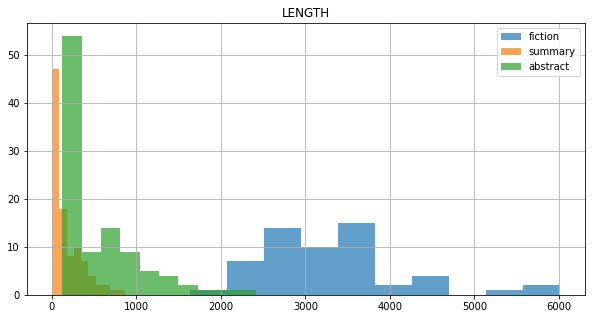

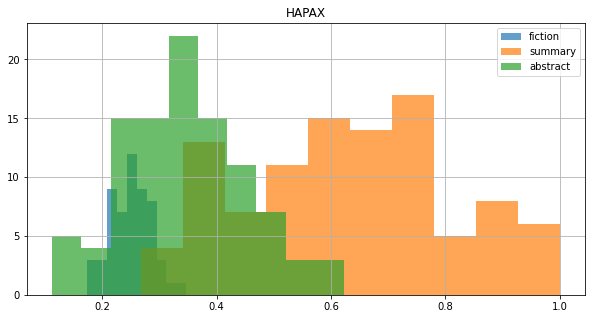

In [18]:
import matplotlib.pyplot as plt

def graph_dist(df, feature, groupby='LABEL', label_dict=label_dict):
    fig, ax = plt.subplots(figsize=(10,5))
    
    for (i, d) in df.groupby(groupby):
        d[feature].hist(ax=ax, label=i, alpha=0.7)
        ax.legend(list(label_dict.values()))
        ax.set_title(feature)
        
    return fig

for feat in ['LENGTH', 'HAPAX']:
    graph_dist(features, feat);

### Grammatical structure: active vs. passive voice

The first of our full text metrics concerns the distinction between active and passive voice. The hypothesis here is that the objective, report-like nature of abstracts (and perhaps summaries) will have more passive voice overall than fiction, which tends to be focused on present action. To measure this, we'll use `spaCy`'s dependency parser to identify the percentage of passive voice subjects in a document.

We'll implement this in a function, which will tally the number of passive subjects and the number of active subjects in each sentence of the document. Then, it will sum together the total number of subjects and divide the number of passive subjects by that total.

In [19]:
def score_passive(doc):
    subjects = {'nsubjpass': 0, 'nsubj': 0}
    for sent in doc.sents:
        for token in sent:
            if token.dep_ in ('nsubjpass', 'nsubj'):
                subjects[token.dep_] += 1
    total_subjects = sum(subjects.values())
    
    return subjects['nsubjpass'] / total_subjects

### Lexicon I: abstract nouns

The code for our second metric will follow a similar structure to the code above. Below, use `spaCy`'s part-of-speech tags to identify nouns in a document. Then we determine whether these are abstract nouns, on the theory that abstracts and summaries are likely to have more nouns that denote ideas, qualities, relationships, etc. than fiction.

But how do we find an abstract noun? One simple way is to consider a noun's suffix. Suffixes like "-acy" or "-ncy" (accuracy, leniency), "-hip" or "-ity" (relationship, fixity) are good, general markers of abstract nouns. They're not always a perfect match, but they can give us a general sense of what kind of noun it is that we're working with.

In [20]:
ABSTRACT_SUFFIX = ('acy', 'ncy', 'nce', 'ism', 'ity', 'ty', 'ent', 'ess', 'hip', 'ion')

def score_abstract(doc):
    nouns = {'abstract': 0, 'not_abstract': 0}
    for token in doc:
        if token.pos_ == 'NOUN':
            if token.suffix_ in ABSTRACT_SUFFIX:
                nouns['abstract'] += 1
            else:
                nouns['not_abstract'] += 1
    total_nouns = sum(nouns.values())
    
    return nouns['abstract'] / total_nouns

### Lexicon II: cardinal numbers

So far we've been eliding potentially important differences between abstracts and summaries. Let's develop a metric that might help us distinguish between the two of them. One such metric could be a simple count of the number of cardinal numbers in a document: we'd expect summaries to have less than abstracts. Using `spaCy`'s part-of-speech tagger will help us identify these tokens.

In [21]:
def num_cardinals(doc):
    numbers = 0
    for token in doc:
        if token.tag_ == 'CD':
            numbers += 1
            
    return ints

Note that we'll want to convert the return from this function into a percentage over total tokens. We'll do so in a later processing function.

### Sentiment